In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from gensim import models, corpora
from ast import literal_eval
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import umap
from sklearn.cluster import AgglomerativeClustering
warnings.filterwarnings('ignore')
%matplotlib inline

## Считывание датасета и предобработка

In [2]:
import pickle
with open('duma/data_dataframe_prep.pickle', 'rb') as dep:
    df = pickle.load(dep)

In [3]:
# Изначальный размер датасета
df.shape

(359330, 14)

In [4]:
df['lenght'] = df['lines'].apply(len)

In [5]:
# Удаление коротких текстов менее 20 слов
df['lenght'] = df['lines'].apply(len)
df = df[df['lenght']>=20].reset_index(drop=True)

In [6]:
df.head(10)

_startLine  _endLine     _type  \
0        1203      1212  65100003   
1        4581      4593  65100003   
2        1819      1830  65100003   
3        2591      2617  65100003   
4        5109      5130  65100007   
5        5681      5690             
6        6102      6110             
7        6149      6155             
8        6215      6226             
9        5278      5288             

                                              _lines _votes  \
0  спасибо уважаемый борис вячеславович уважаемые...     []   
1  уважаемый председательствующий уважаемые колле...     []   
2  фракция единая россия уважаемый председательст...     []   
3  фракция единая россия уважаемый председательст...     []   
4  фракция единая россия уважаемый председательст...     []   
5  комитет по безопасности ознакомился с данным п...     []   
6  фракция единая россия уважаемый председательст...     []   
7  уважаемый председательствующий уважаемые колле...     []   
8  фракция единая россия спасибо уважаемый предсе...     []   
9  фракция единая россия уважаемый председательст...     []   

                         name pageSize page totalCount questionCount  \
0  Колесников Виктор Иванович       20    1        348           193   
1  Колесников Виктор Иванович       20    1        348           193   
2  Колесников Виктор Иванович       20    1        348           193   
3  Колесников Виктор Иванович       20    1        348           193   
4  Колесников Виктор Иванович       20    1        348           193   
5  Колесников Виктор Иванович       20    1        348           193   
6  Колесников Виктор Иванович       20    1        348           193   
7  Колесников Виктор Иванович       20    1        348           193   
8  Колесников Виктор Иванович       20    1        348           193   
9  Колесников Виктор Иванович       20    1        348           193   

         meetings.date  deputies party  \
0  2011-11-18 00:00:00  99102994  None   
1  2011-11-18 00:00:00  99102994  None   
2  2011-10-21 00:00:00  99102994  None   
3  2011-10-18 00:00:00  99102994  None   
4  2011-09-21 00:00:00  99102994  None   
5  2011-09-21 00:00:00  99102994  None   
6  2011-09-20 00:00:00  99102994  None   
7  2011-09-20 00:00:00  99102994  None   
8  2011-09-06 00:00:00  99102994  None   
9  2011-07-06 00:00:00  99102994  None   

                                               lines  lenght  
0  [спасибо, уважаемый, борис, вячеславович, уваж...      46  
1  [уважаемый, председательствующий, уважаемый, к...      48  
2  [фракция, единый, россия, уважаемый, председат...      41  
3  [фракция, единый, россия, уважаемый, председат...     124  
4  [фракция, единый, россия, уважаемый, председат...      96  
5  [комитет, безопасность, ознакомляться, данный,...      43  
6  [фракция, единый, россия, уважаемый, председат...      25  
7  [уважаемый, председательствующий, уважаемый, к...      33  
8  [фракция, единый, россия, спасибо, уважаемый, ...      46  
9  [фракция, единый, россия, уважаемый, председат...      45

In [7]:
# Получившийся размер датасета
df.shape

(282904, 15)

In [8]:
df['meetings.date'] = pd.to_datetime(df['meetings.date'])
df[['party']].fillna(value='non_party', inplace=True)
df['year'] = df['meetings.date'].dt.year
df['year'] = df['year'].astype('int64')

In [9]:
def model(bag, ntopic=30):
    '''Функция обучения и получения модели тематического моделирования'''
    bigram = models.Phrases(bag, min_count=3, threshold=5) 
    bigram_mod = models.phrases.Phraser(bigram) 
    def make_bigrams(texts): 
        return [bigram_mod[doc] for doc in texts]
    texts = make_bigrams(bag)
    dictionary = corpora.Dictionary(texts) 
    dictionary.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6) 
    corpus = [dictionary.doc2bow(text) for text in texts] 
    ldamodel = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, eval_every=20, num_topics=ntopic, passes=5, random_state=2)
    return ldamodel, corpus

In [10]:
# Составляем мешок слов, поскольку предварительная обработка была проведена, то переводим строки в списки токенов
bag_of_words = df.lines

## Построение модели LDA

In [11]:
# Составляем мешок слов
bag_of_words = df.lines

In [12]:
%%time
# Обучаем модель
ldamodel, corpus = model(bag_of_words)

CPU times: user 2h 28min 7s, sys: 4min 2s, total: 2h 32min 9s
Wall time: 21min 14s


In [13]:
%%time
# Получение векторов тем
vector = pd.DataFrame([dict(i) for i in ldamodel.get_document_topics(corpus, minimum_probability=0)])

CPU times: user 25min 13s, sys: 27.3 s, total: 25min 40s
Wall time: 2min 21s


## Визуализация

##### Heatmap по годам

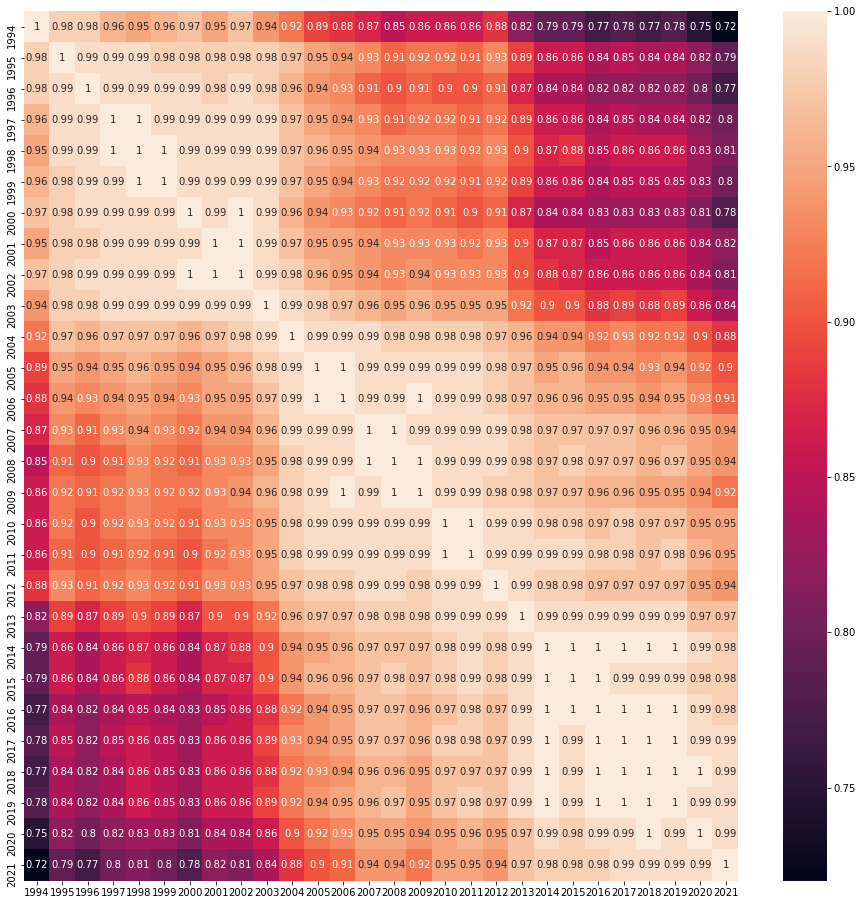

In [14]:
# Визуализация heatmap, показывающая насколько близки года по косинусному расстоянию между темами в стенограммах
total = pd.concat([df[['party', 'year']], vector], axis=1)
ind = total.groupby(['year']).mean().index
plt.figure(figsize=(16, 16))
sns.heatmap(np.round(cosine_similarity(total.groupby(['year']).mean()),2), annot=True, xticklabels=ind, yticklabels=ind)
plt.show()

In [15]:
# Таблица векторов тем по партиям и годам 
total.head(10)

party  year         0         1         2         3         4         5  \
0  None  2011  0.055652  0.000953  0.000953  0.000953  0.000953  0.000953   
1  None  2011  0.000981  0.000981  0.000981  0.000981  0.000981  0.000981   
2  None  2011  0.001193  0.001193  0.001193  0.001193  0.001193  0.001193   
3  None  2011  0.000388  0.000388  0.000388  0.000388  0.044128  0.000388   
4  None  2011  0.000499  0.000499  0.000499  0.000499  0.000499  0.000499   
5  None  2011  0.000953  0.000953  0.000953  0.000953  0.095004  0.000953   
6  None  2011  0.001667  0.001667  0.001667  0.001667  0.001667  0.001667   
7  None  2011  0.064724  0.001390  0.001390  0.001390  0.001390  0.001390   
8  None  2011  0.001076  0.001076  0.001076  0.001076  0.001076  0.037278   
9  None  2011  0.001150  0.001150  0.001150  0.001150  0.001150  0.001150   

          6         7  ...        20        21        22        23        24  \
0  0.000953  0.000953  ...  0.000953  0.000953  0.000953  0.000953  0.039889   
1  0.000981  0.000981  ...  0.000981  0.000981  0.000981  0.000981  0.276844   
2  0.043539  0.090498  ...  0.001193  0.001193  0.001193  0.001193  0.001193   
3  0.077451  0.000388  ...  0.000388  0.000388  0.000388  0.000388  0.050495   
4  0.014894  0.000499  ...  0.000499  0.000499  0.000499  0.000499  0.000499   
5  0.000953  0.000953  ...  0.000953  0.000953  0.000953  0.000953  0.000953   
6  0.001667  0.001667  ...  0.001667  0.001667  0.001667  0.001667  0.001667   
7  0.001390  0.001390  ...  0.001390  0.001390  0.001390  0.001390  0.209914   
8  0.001076  0.001076  ...  0.001076  0.001076  0.001076  0.001076  0.001076   
9  0.001150  0.001150  ...  0.001150  0.001150  0.001150  0.001150  0.001150   

         25        26        27        28        29  
0  0.199820  0.000953  0.000953  0.000953  0.679874  
1  0.000981  0.000981  0.000981  0.000981  0.643840  
2  0.001193  0.001193  0.001193  0.143016  0.642379  
3  0.000388  0.000388  0.000388  0.348281  0.370387  
4  0.000499  0.000499  0.000499  0.238184  0.556115  
5  0.000953  0.000953  0.000953  0.059918  0.000953  
6  0.001667  0.001667  0.001667  0.001667  0.001667  
7  0.001390  0.001390  0.001390  0.291364  0.001390  
8  0.001076  0.001076  0.001076  0.054690  0.001076  
9  0.001150  0.001150  0.001150  0.001150  0.238591  

[10 rows x 32 columns]

##### UMAP визуализация по годам

In [87]:
party = total.groupby(['party', 'year']).mean().reset_index()
year = total.groupby(['year']).mean().reset_index()
um = umap.UMAP(metric='cosine', min_dist=0.0, random_state=10)
u1 = um.fit_transform(party.iloc[:,2:])
u2 = um.fit_transform(year.iloc[:,1:])
party = np.concatenate((party.iloc[:,:2], u1), axis=1)
year = np.concatenate((year.iloc[:,:1], u2), axis=1)

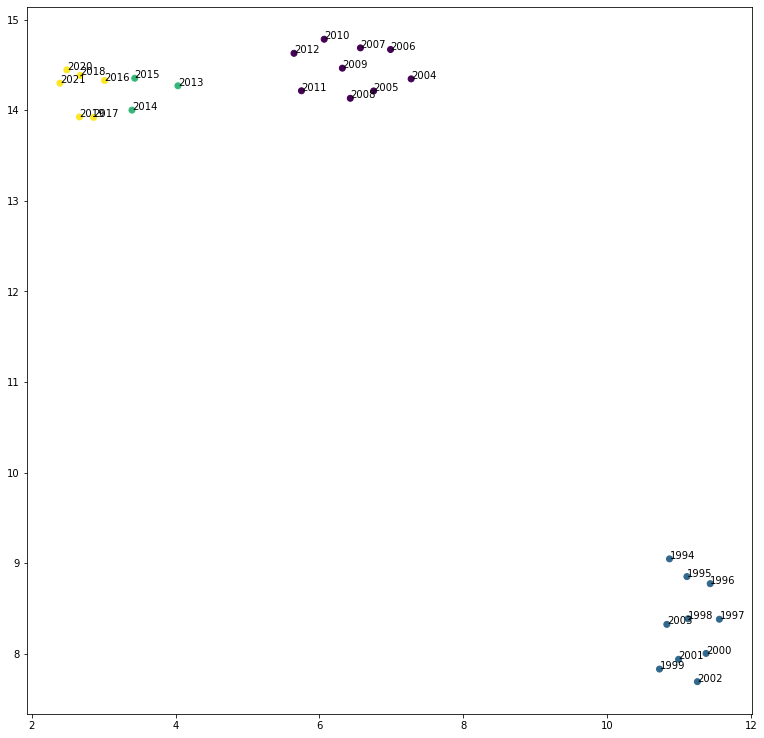

In [92]:
# Иерархическая кластеризация лет на 5 кластеров
AC = AgglomerativeClustering(4, affinity='cosine', linkage='average')
AC.fit(year[:,1:])
plt.figure(figsize=(13, 13))

plt.scatter(year[:,1], year[:,2], c=AC.labels_)
for x,y,z in zip(year[:,1], year[:,2], year[:,0]):
    label = "{}".format(int(z))
    plt.annotate(label, (x,y))
plt.show()

##### UMAP визуализация партий по годам

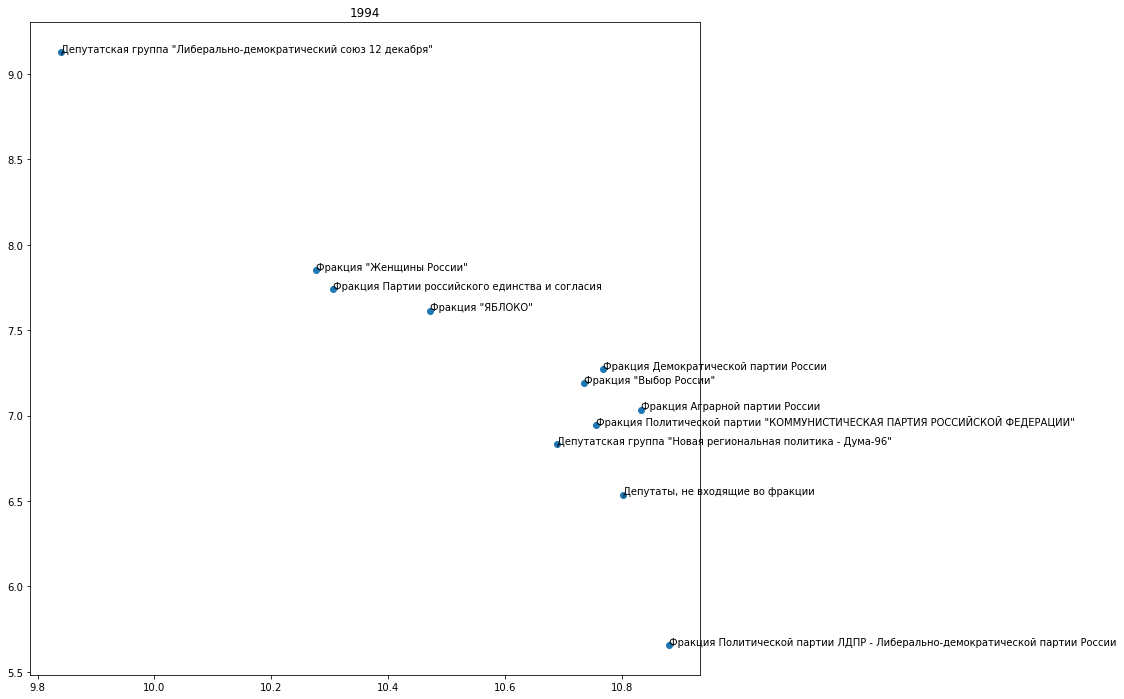

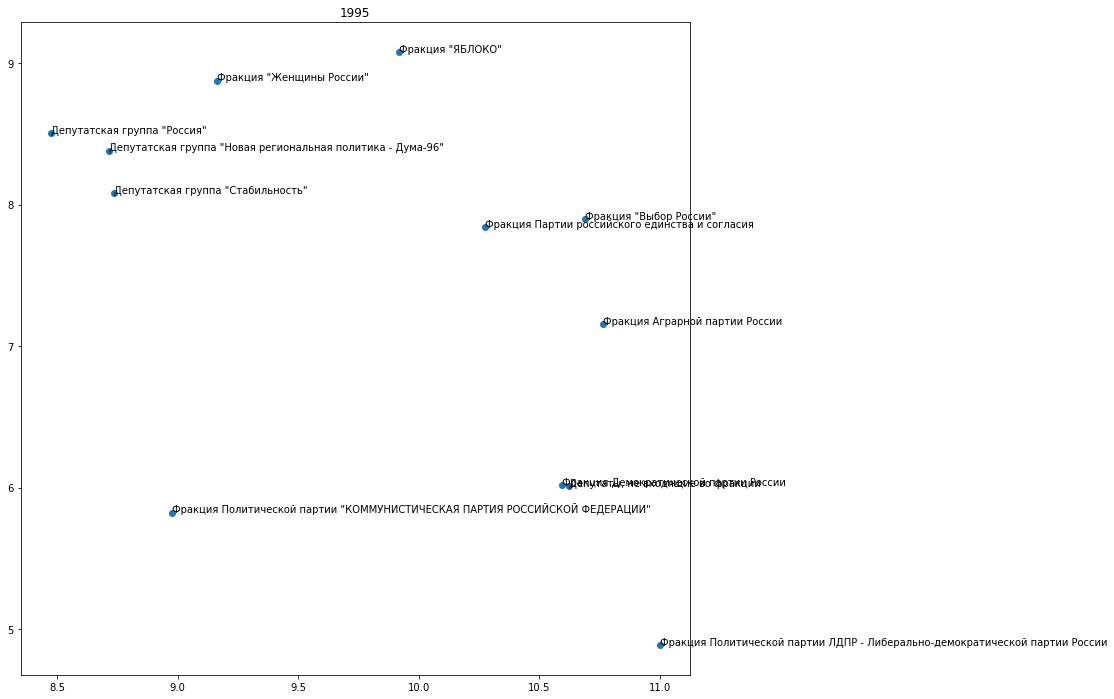

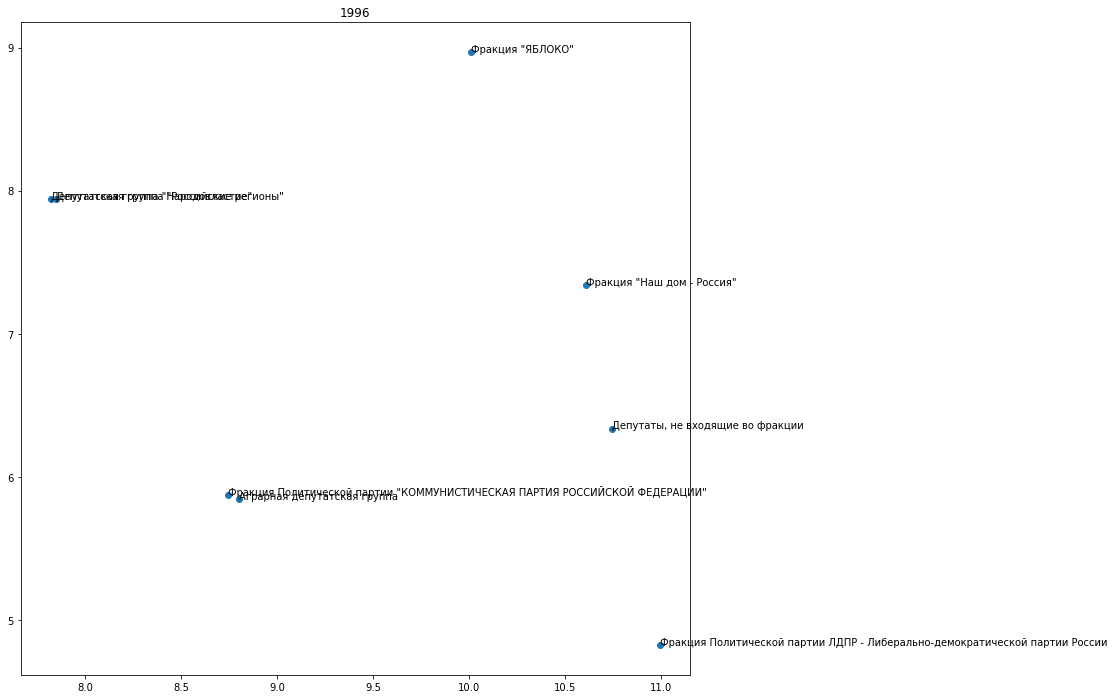

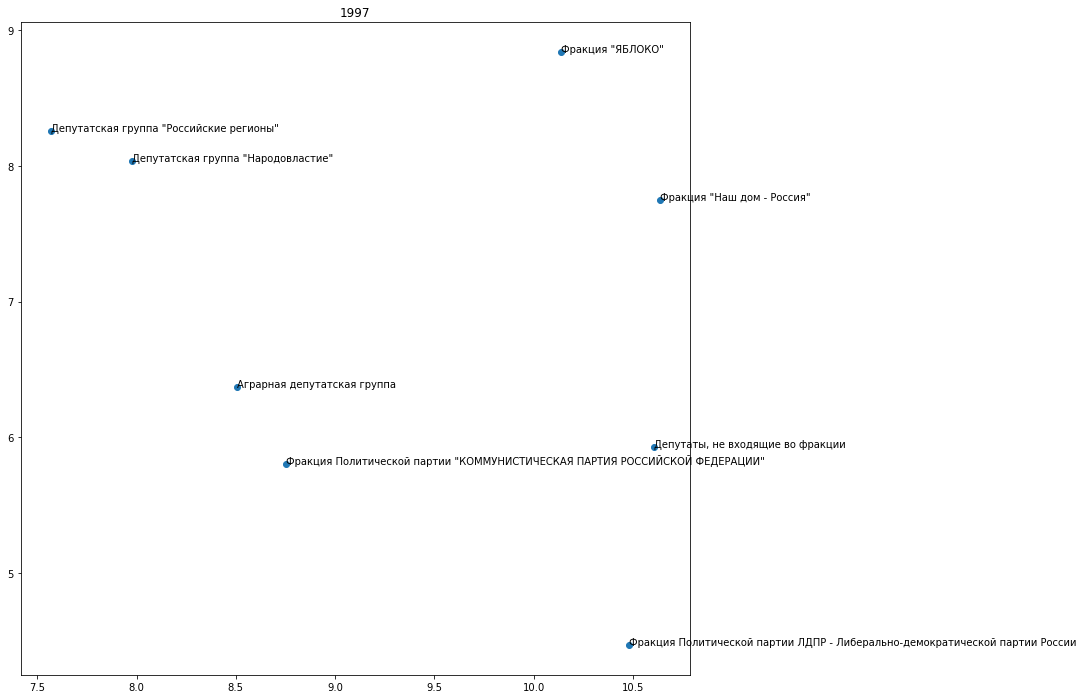

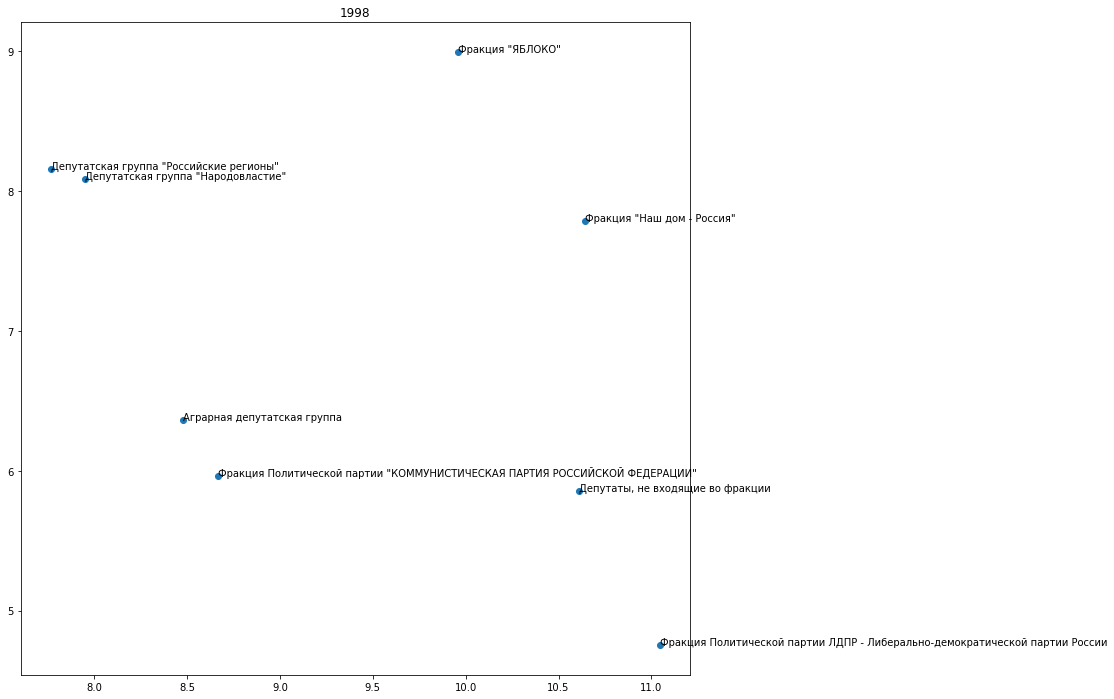

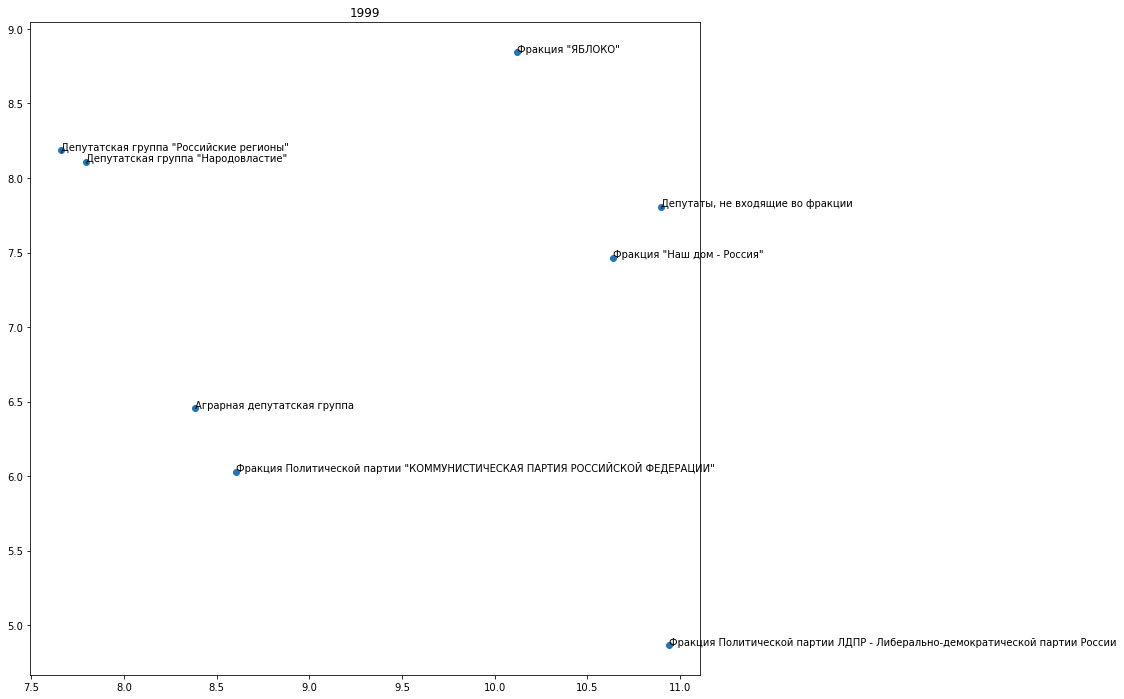

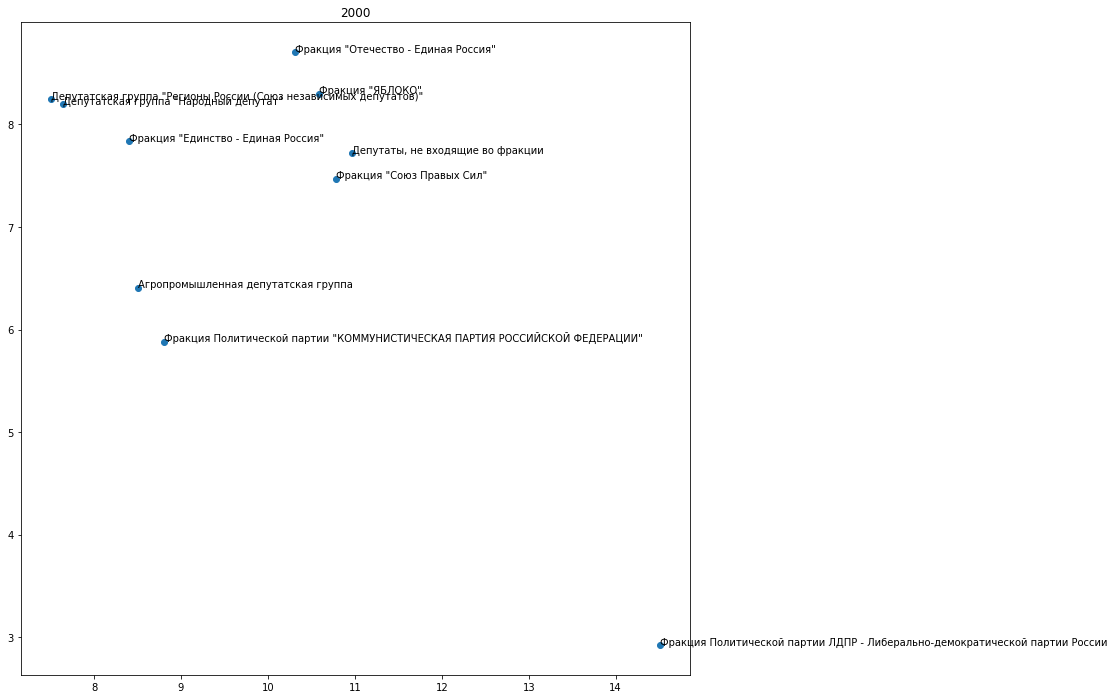

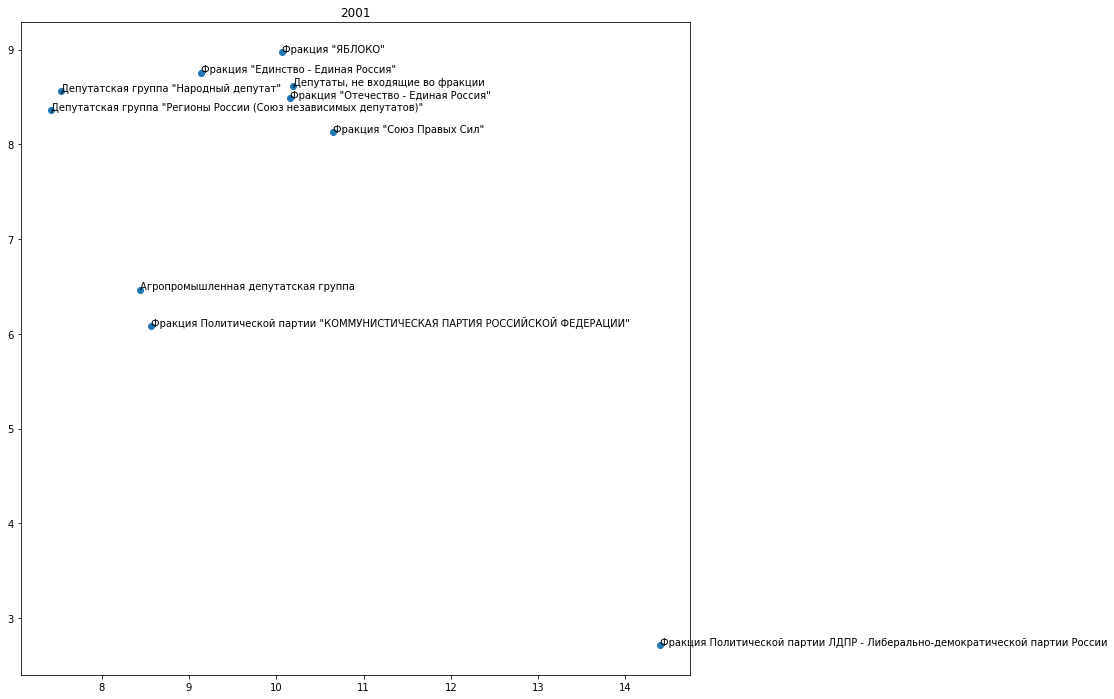

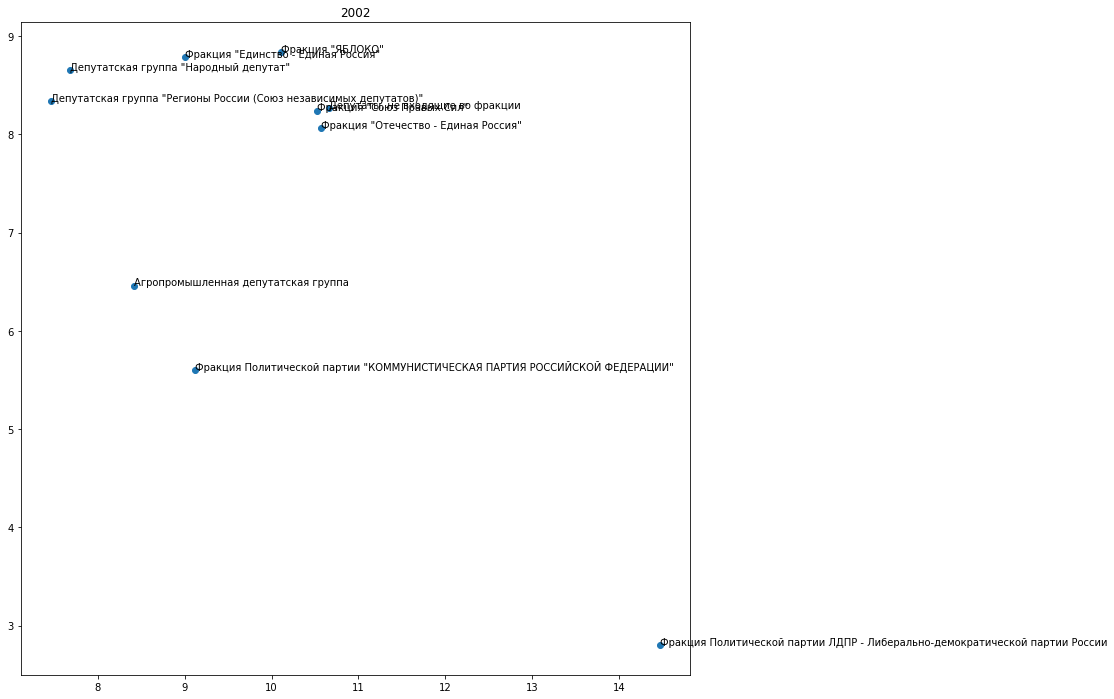

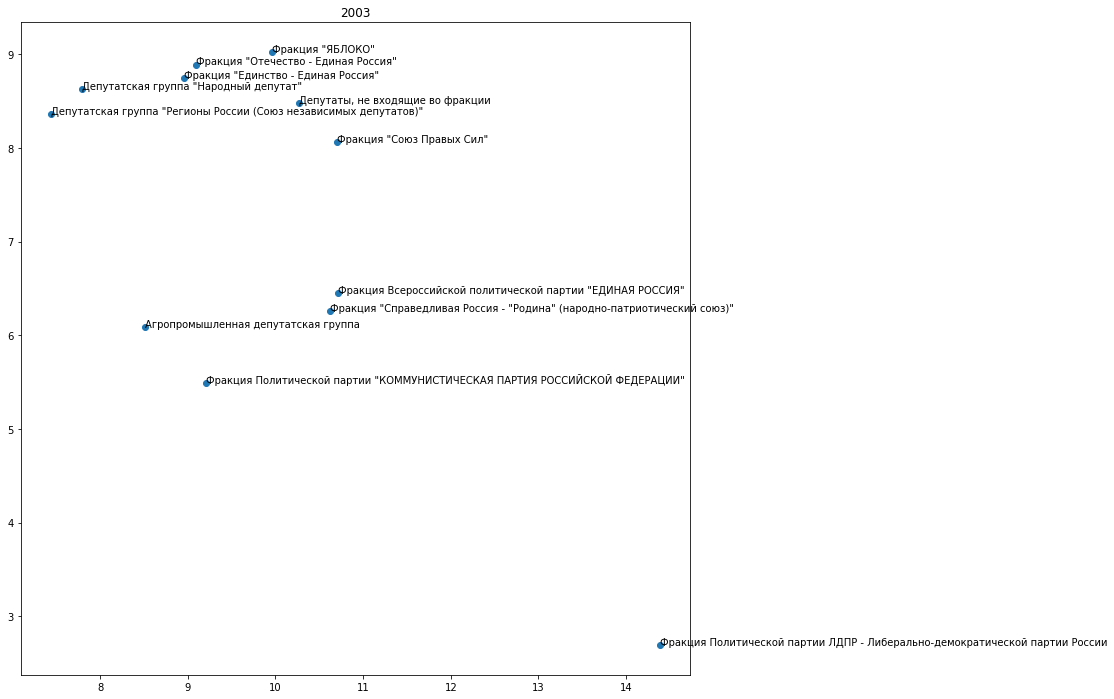

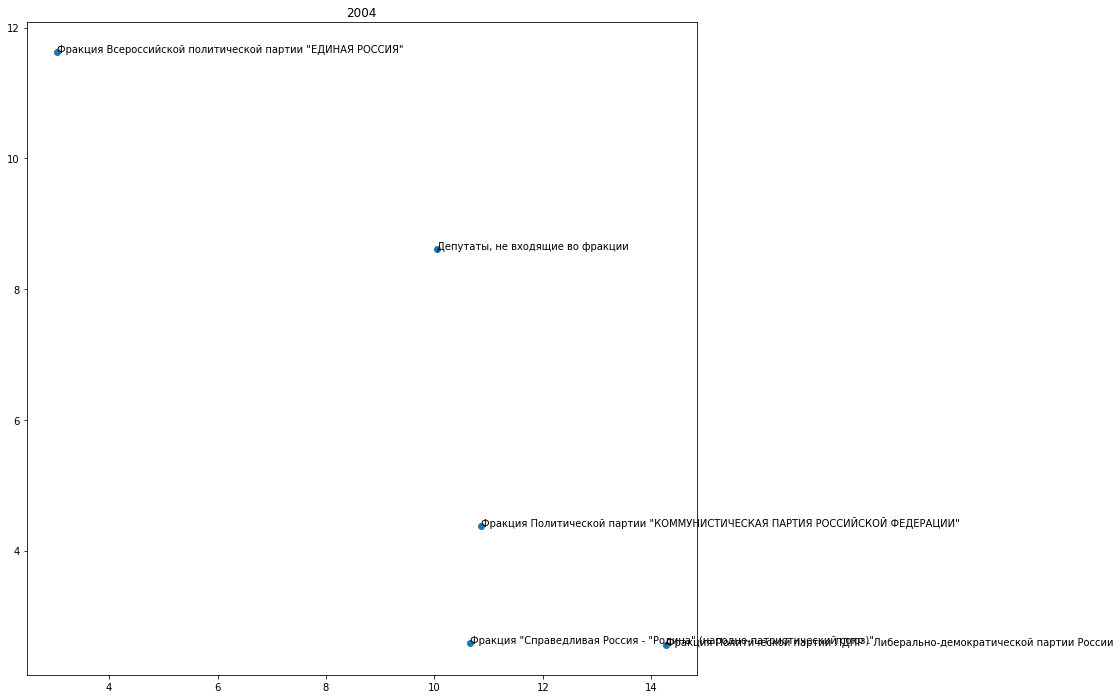

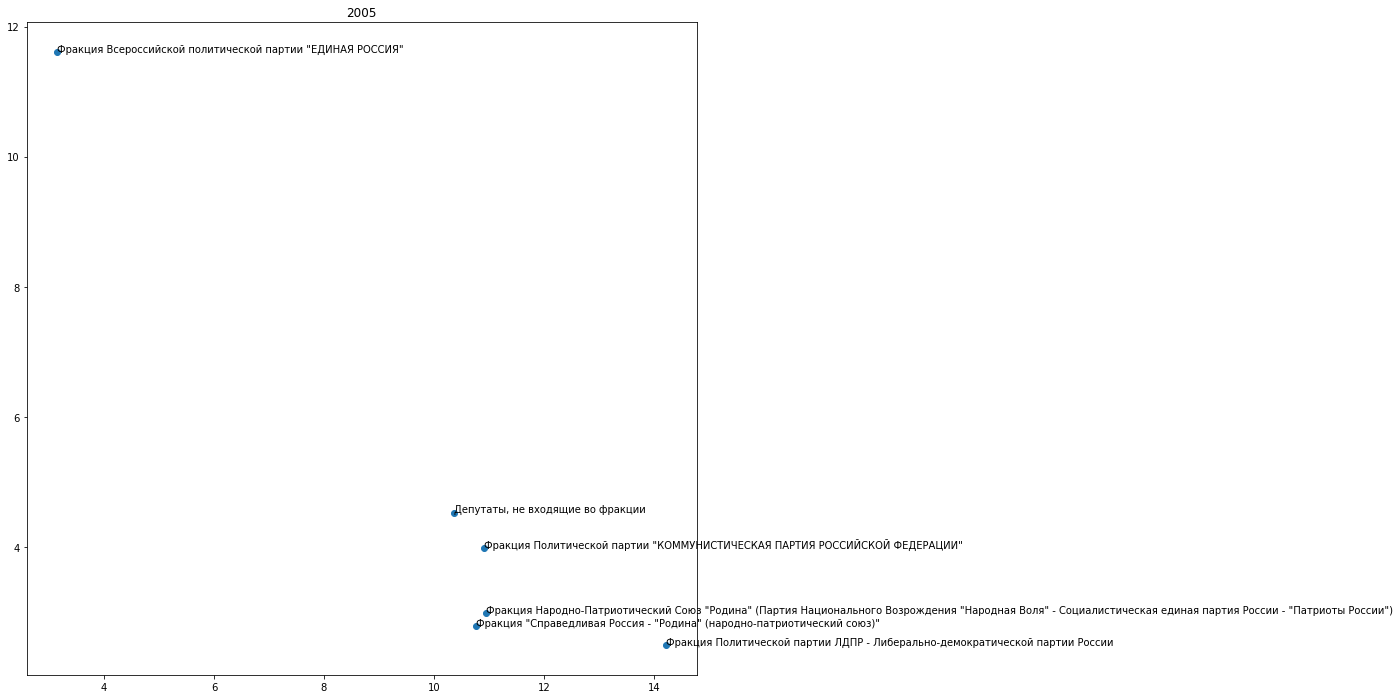

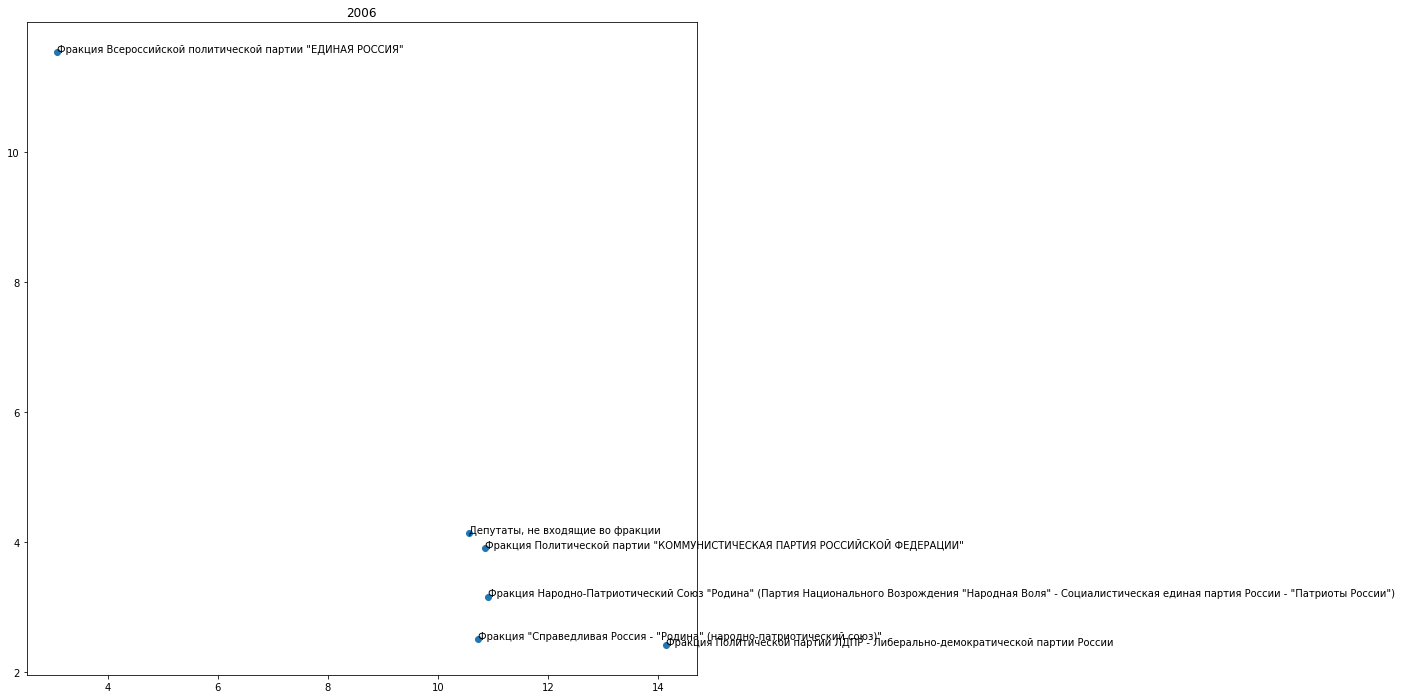

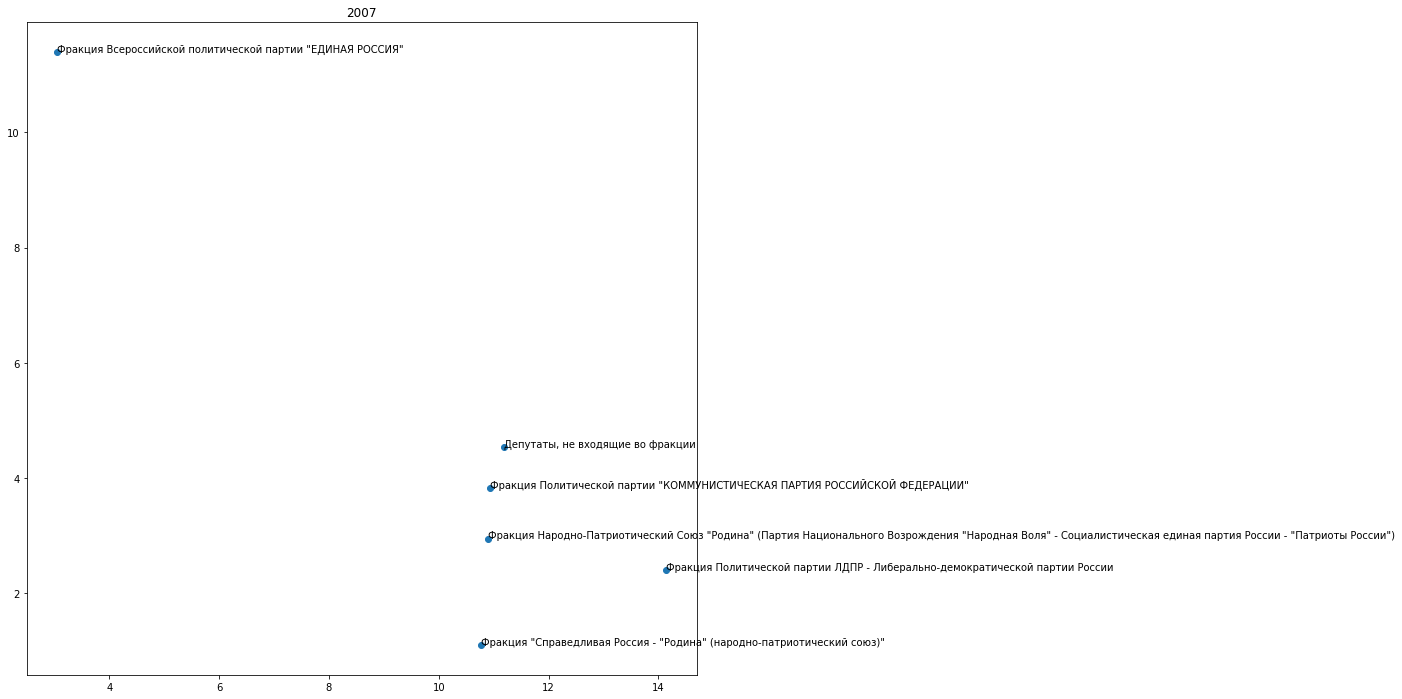

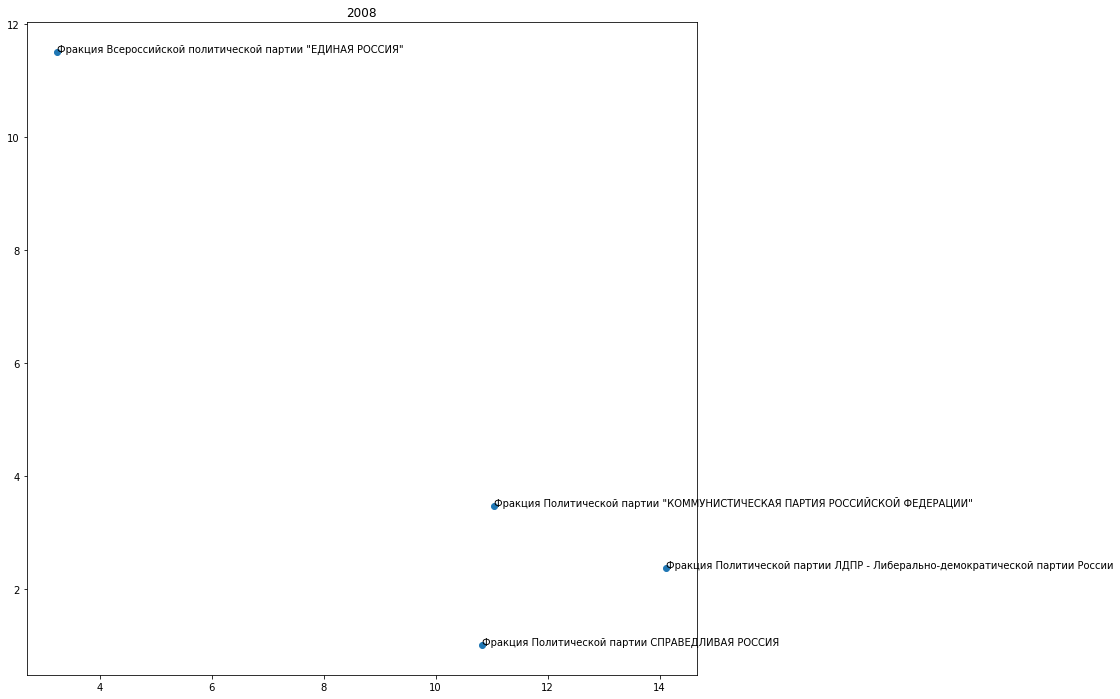

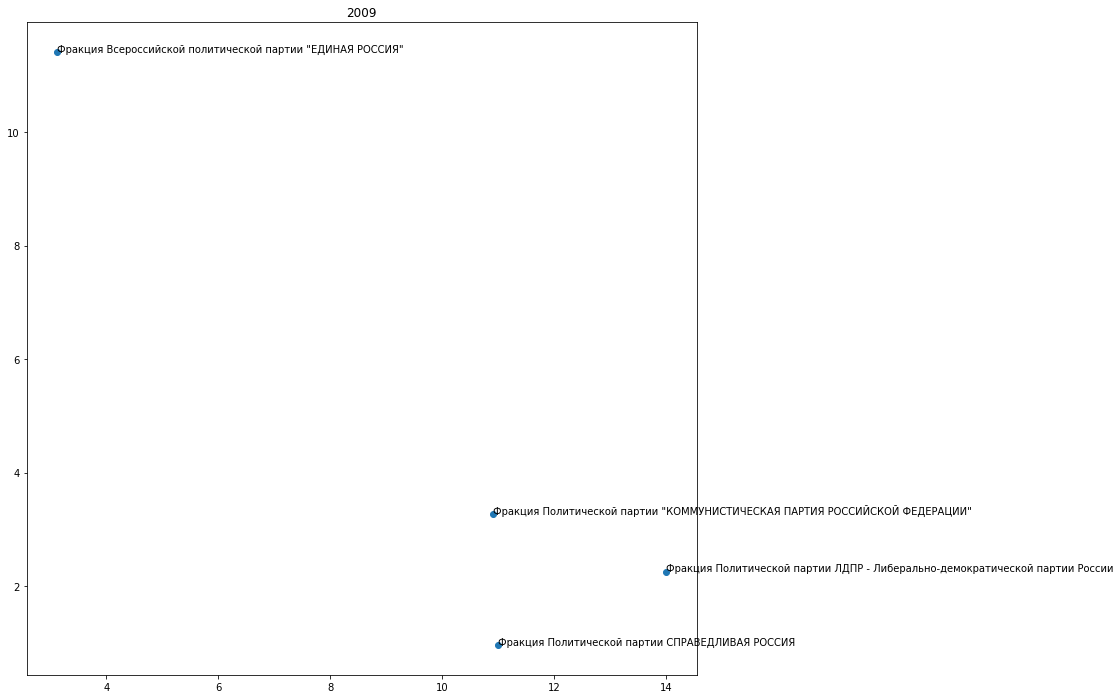

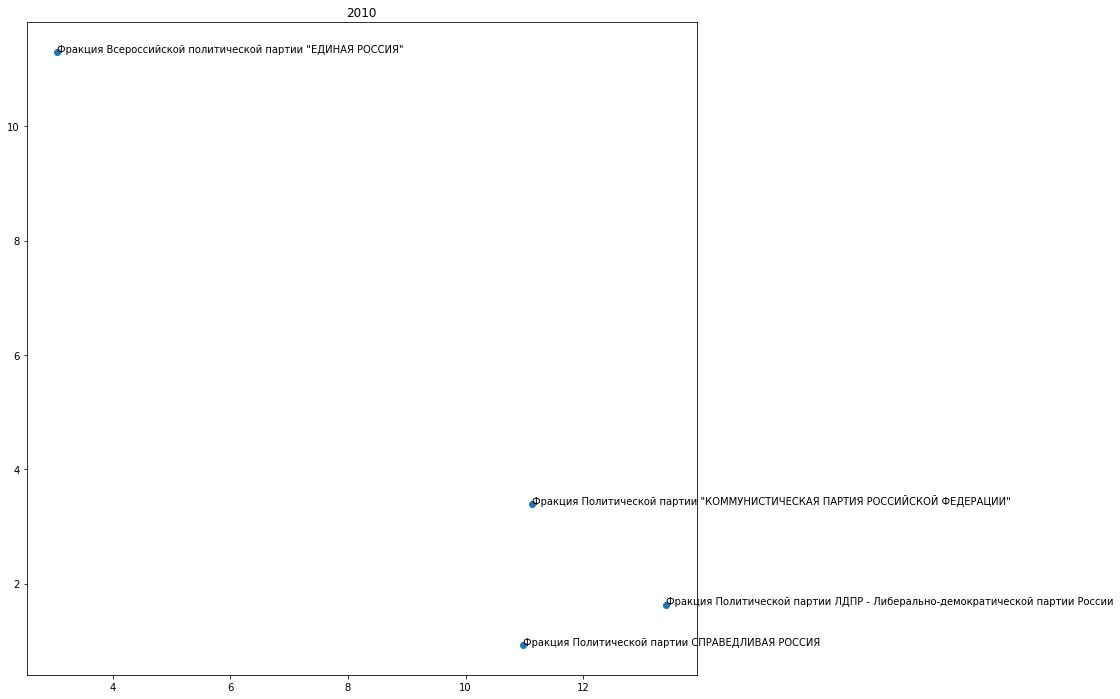

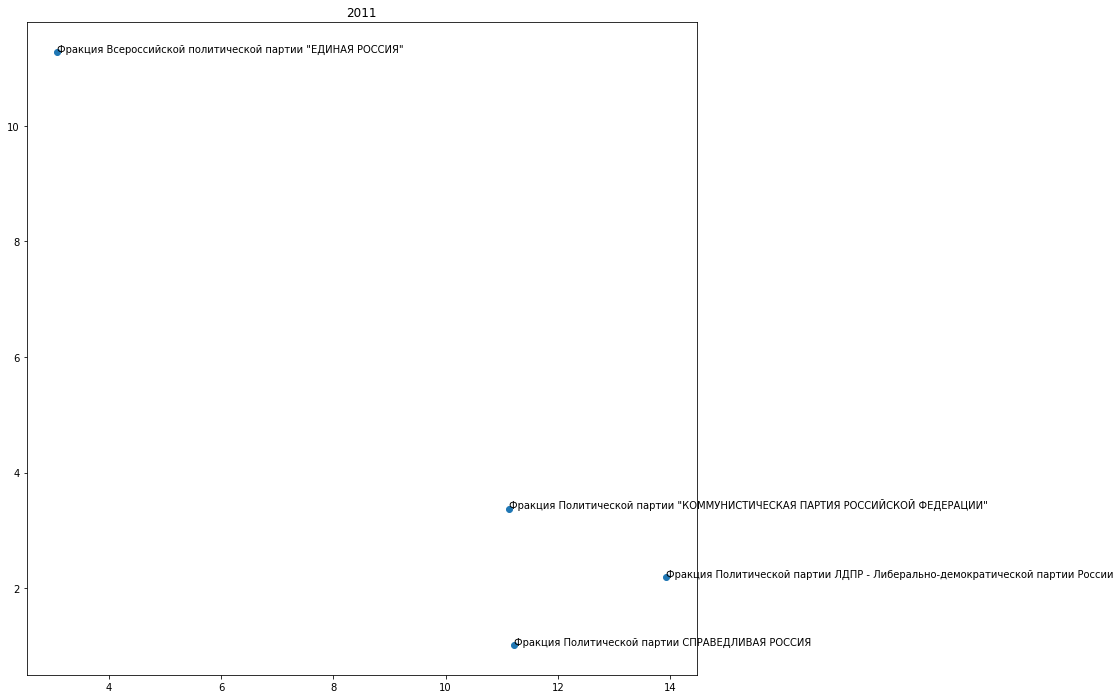

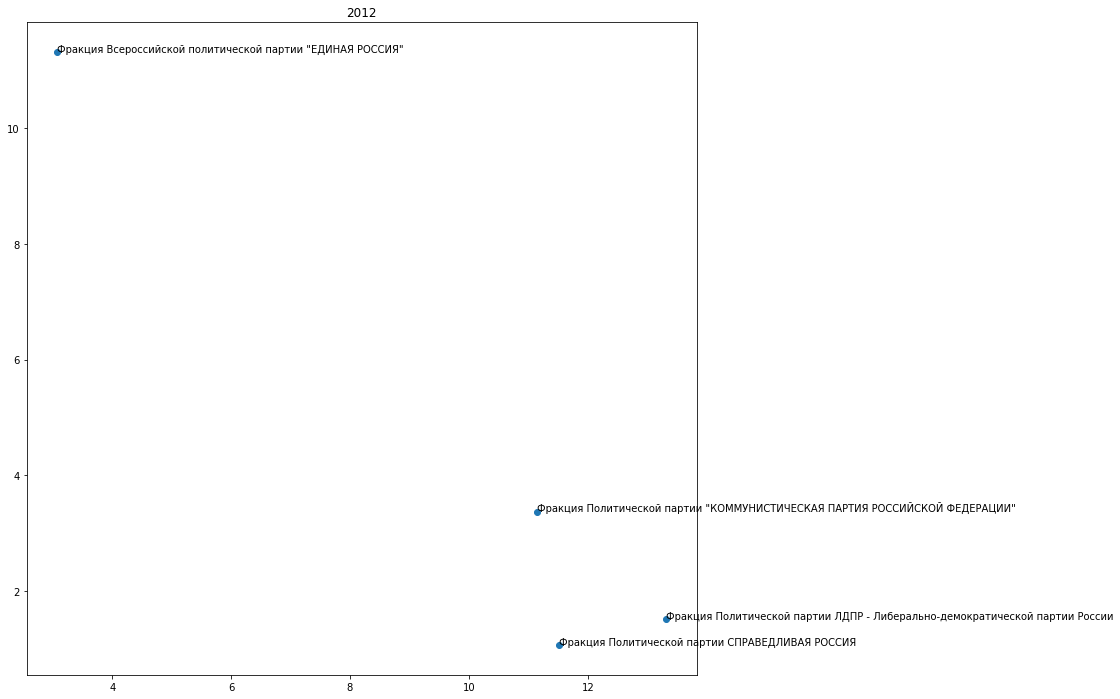

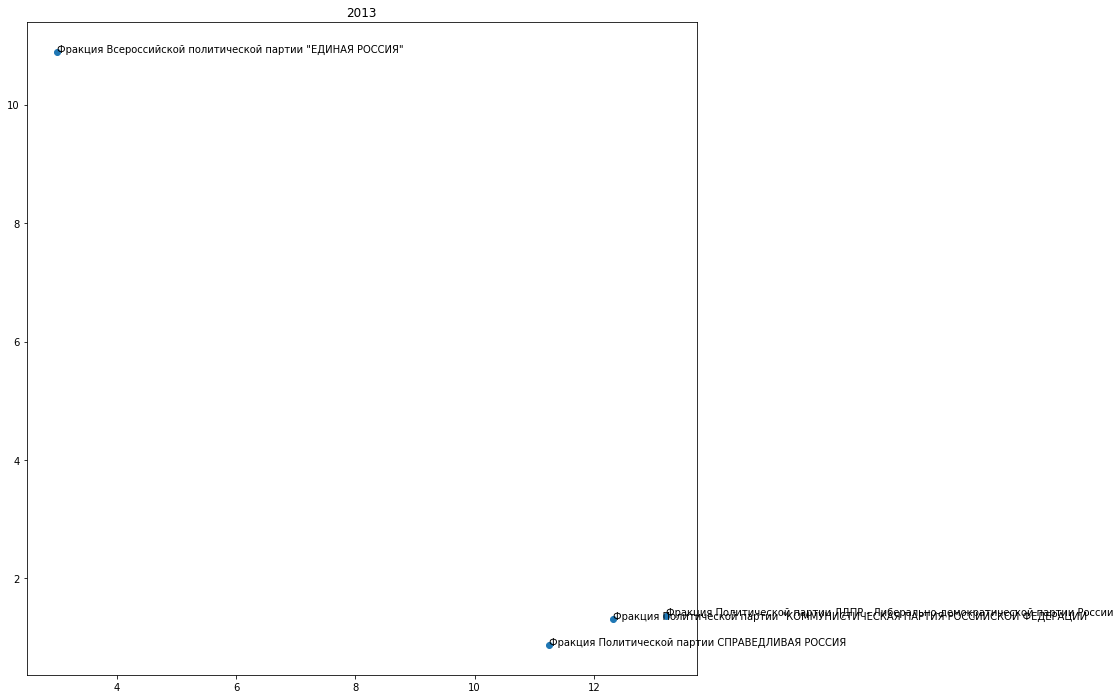

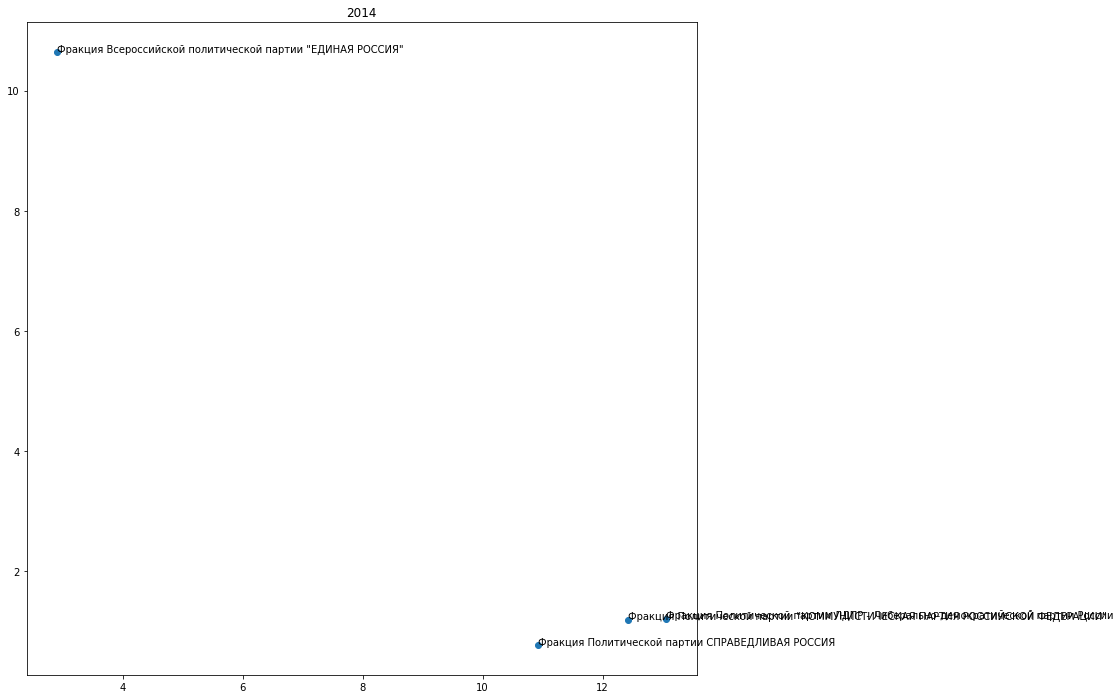

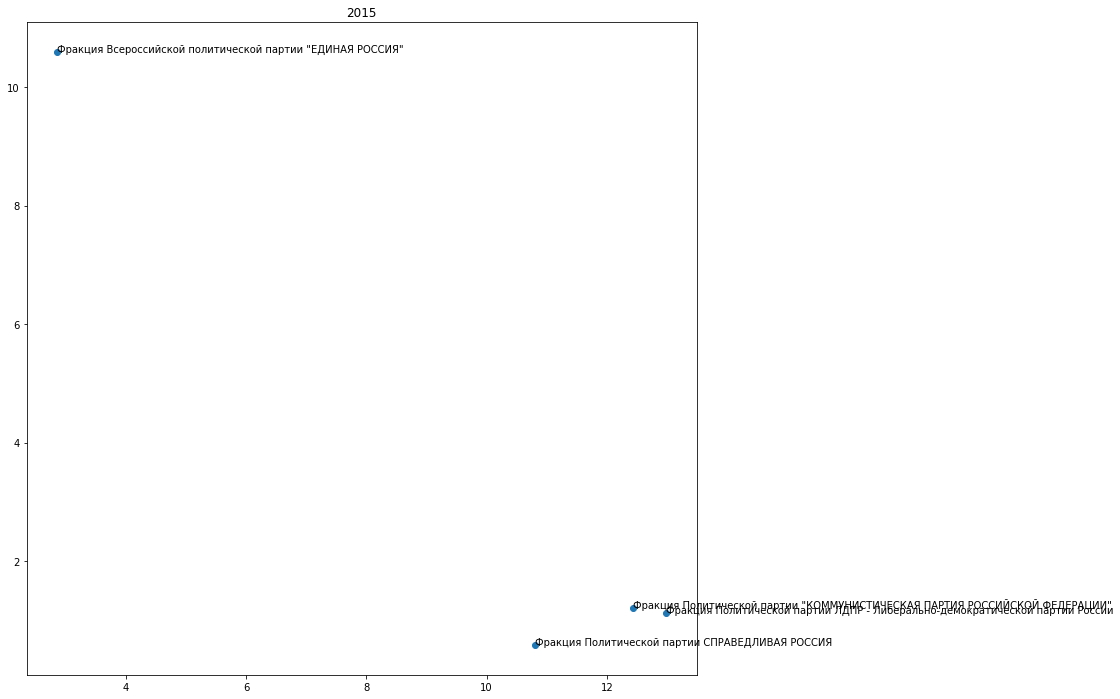

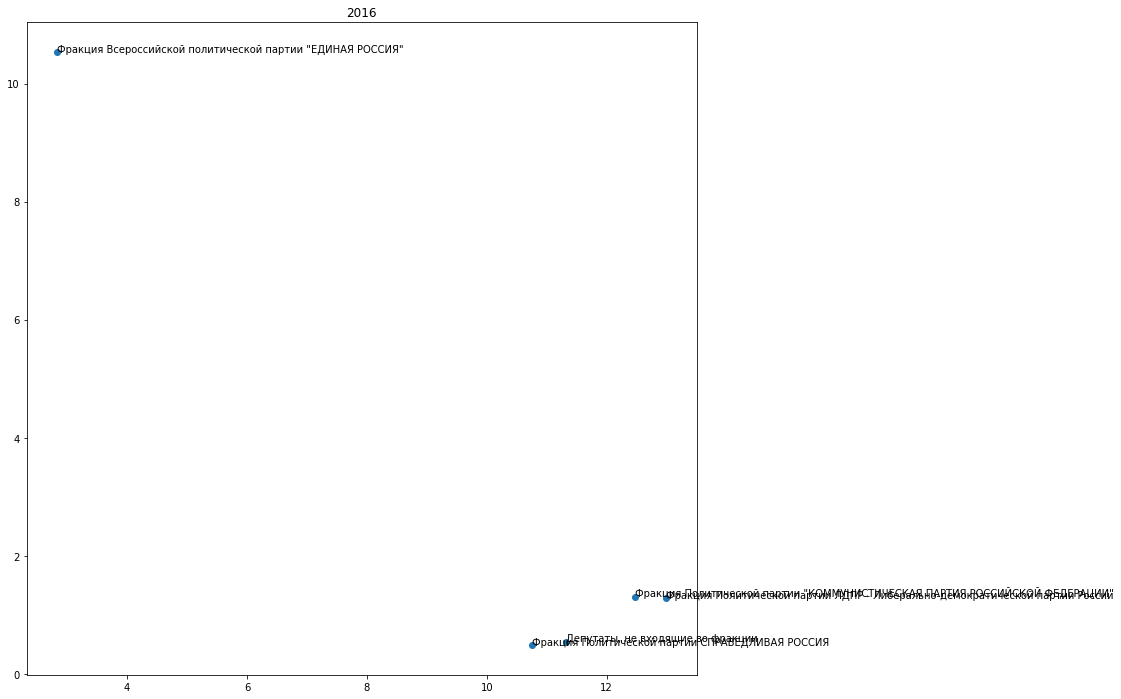

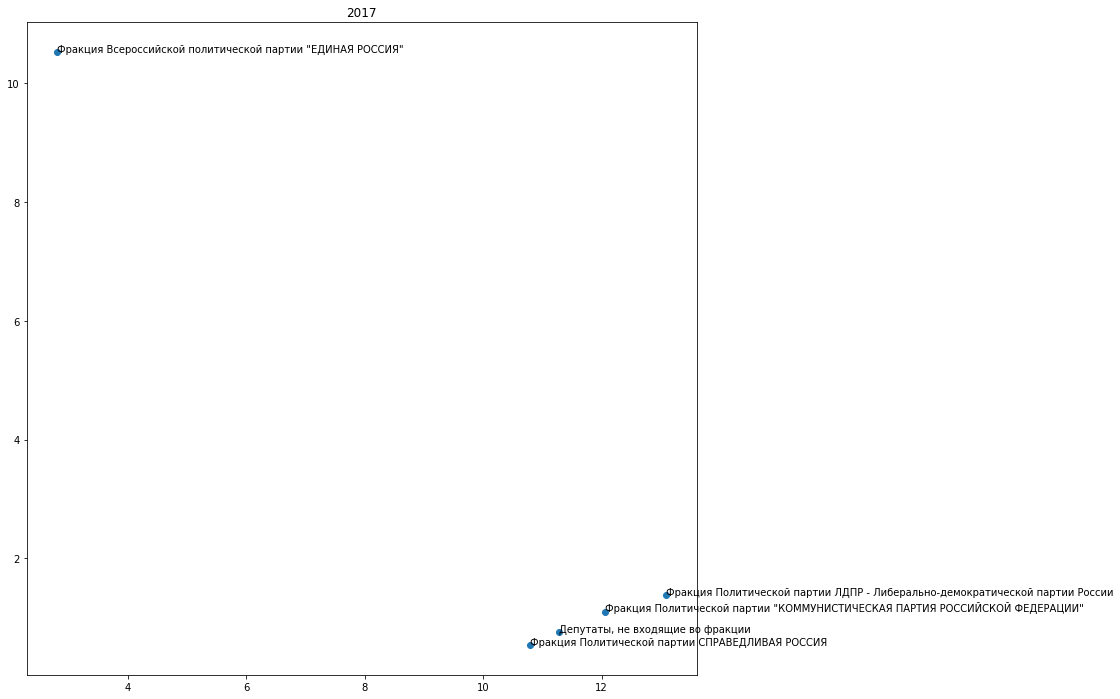

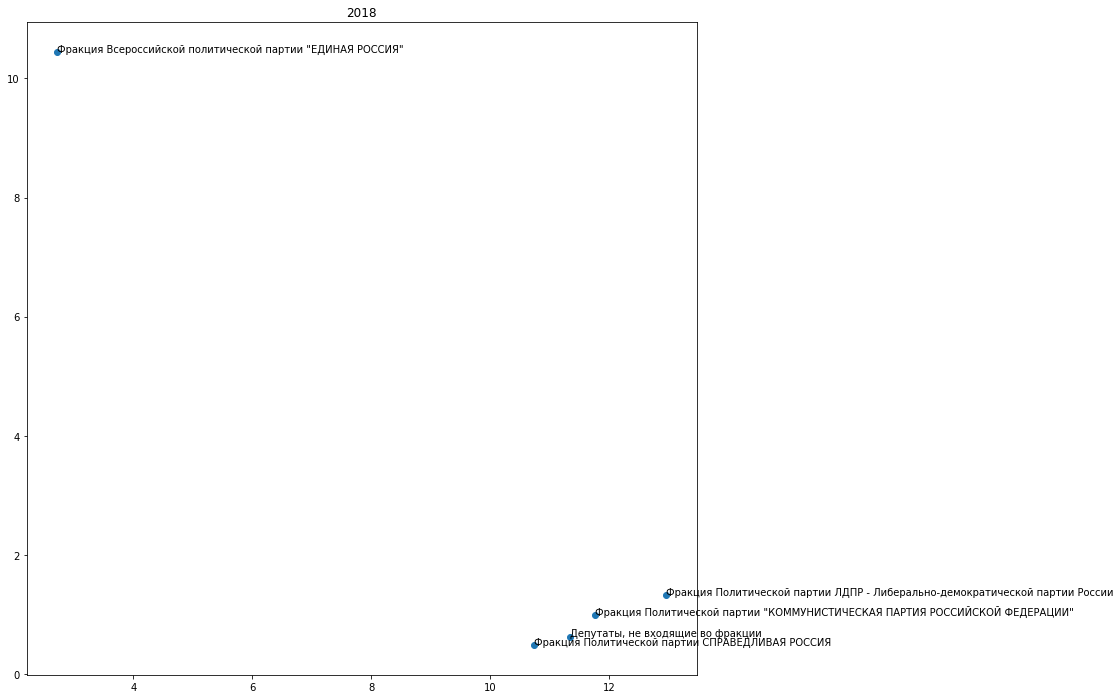

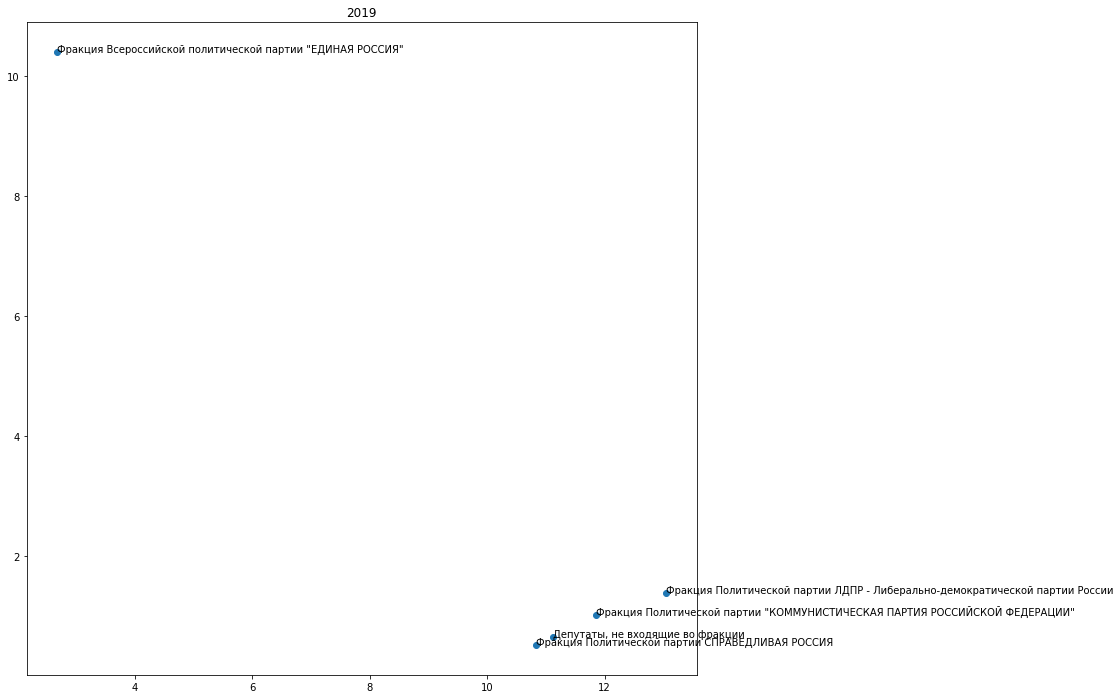

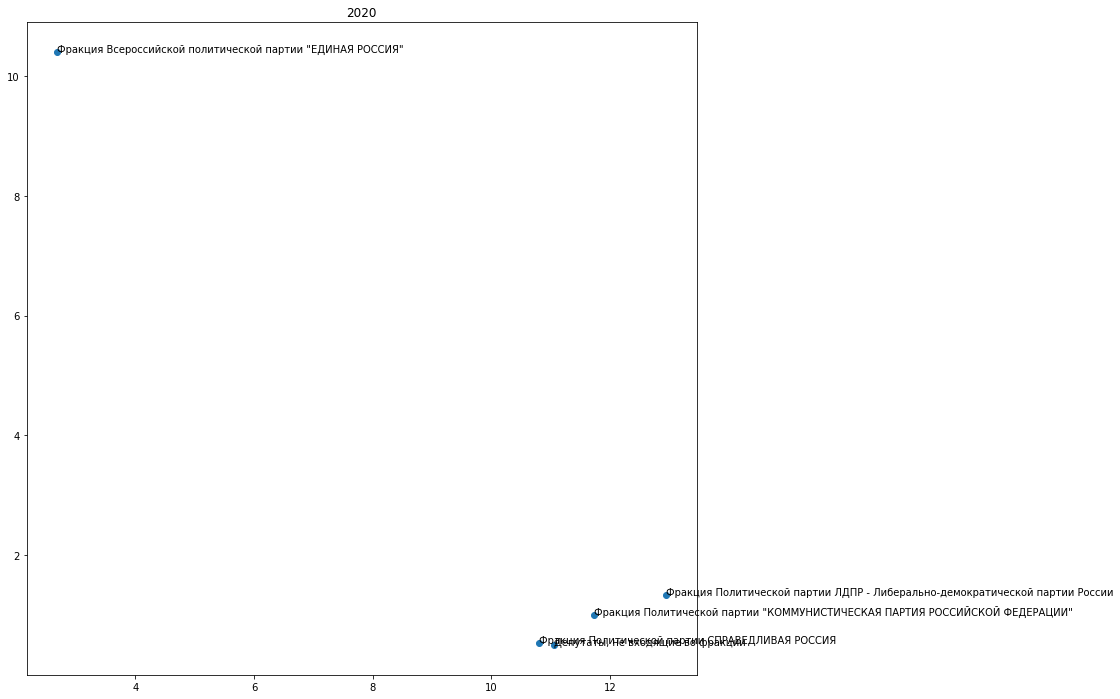

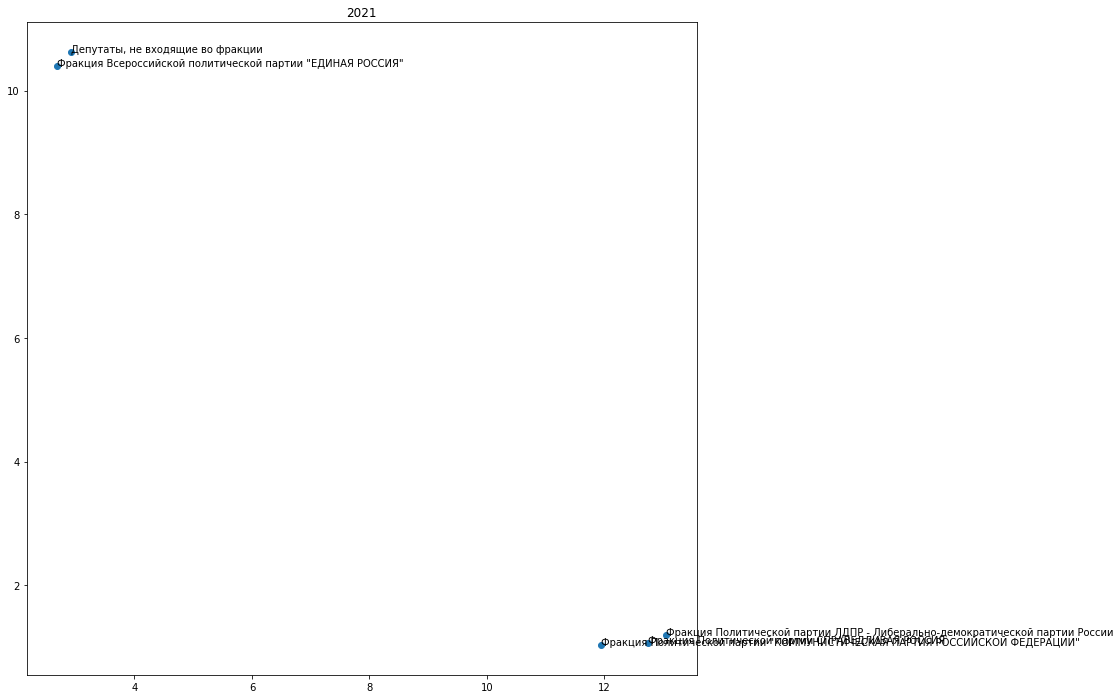

In [32]:
y = set(party[:,1])
j = 0
for i in y:
    p = np.array([x for x in party if x[1] == i])
    plt.figure(figsize=(12,12))
    plt.scatter(p[:,2], p[:,3])
    plt.title(i)
    for x,y,z in zip(p[:,2], p[:,3], p[:,0]):
        label = "{}".format(z)
        plt.annotate(label, (x,y))
    plt.show()

##### Топовые темы по годам

In [20]:
%%time
# Получение топовых тем по каждому оду отдельно
top = []
y = set(df.year)
for i in y:
    bag_of_words = df[df['year'] == i].lines
    ldamodel, _ = model(bag_of_words)
    top.append([i, ldamodel.show_topics(num_topics=30, num_words=20, formatted=False)[:6]])

CPU times: user 2h 44min 24s, sys: 4min 24s, total: 2h 48min 48s
Wall time: 19min 36s


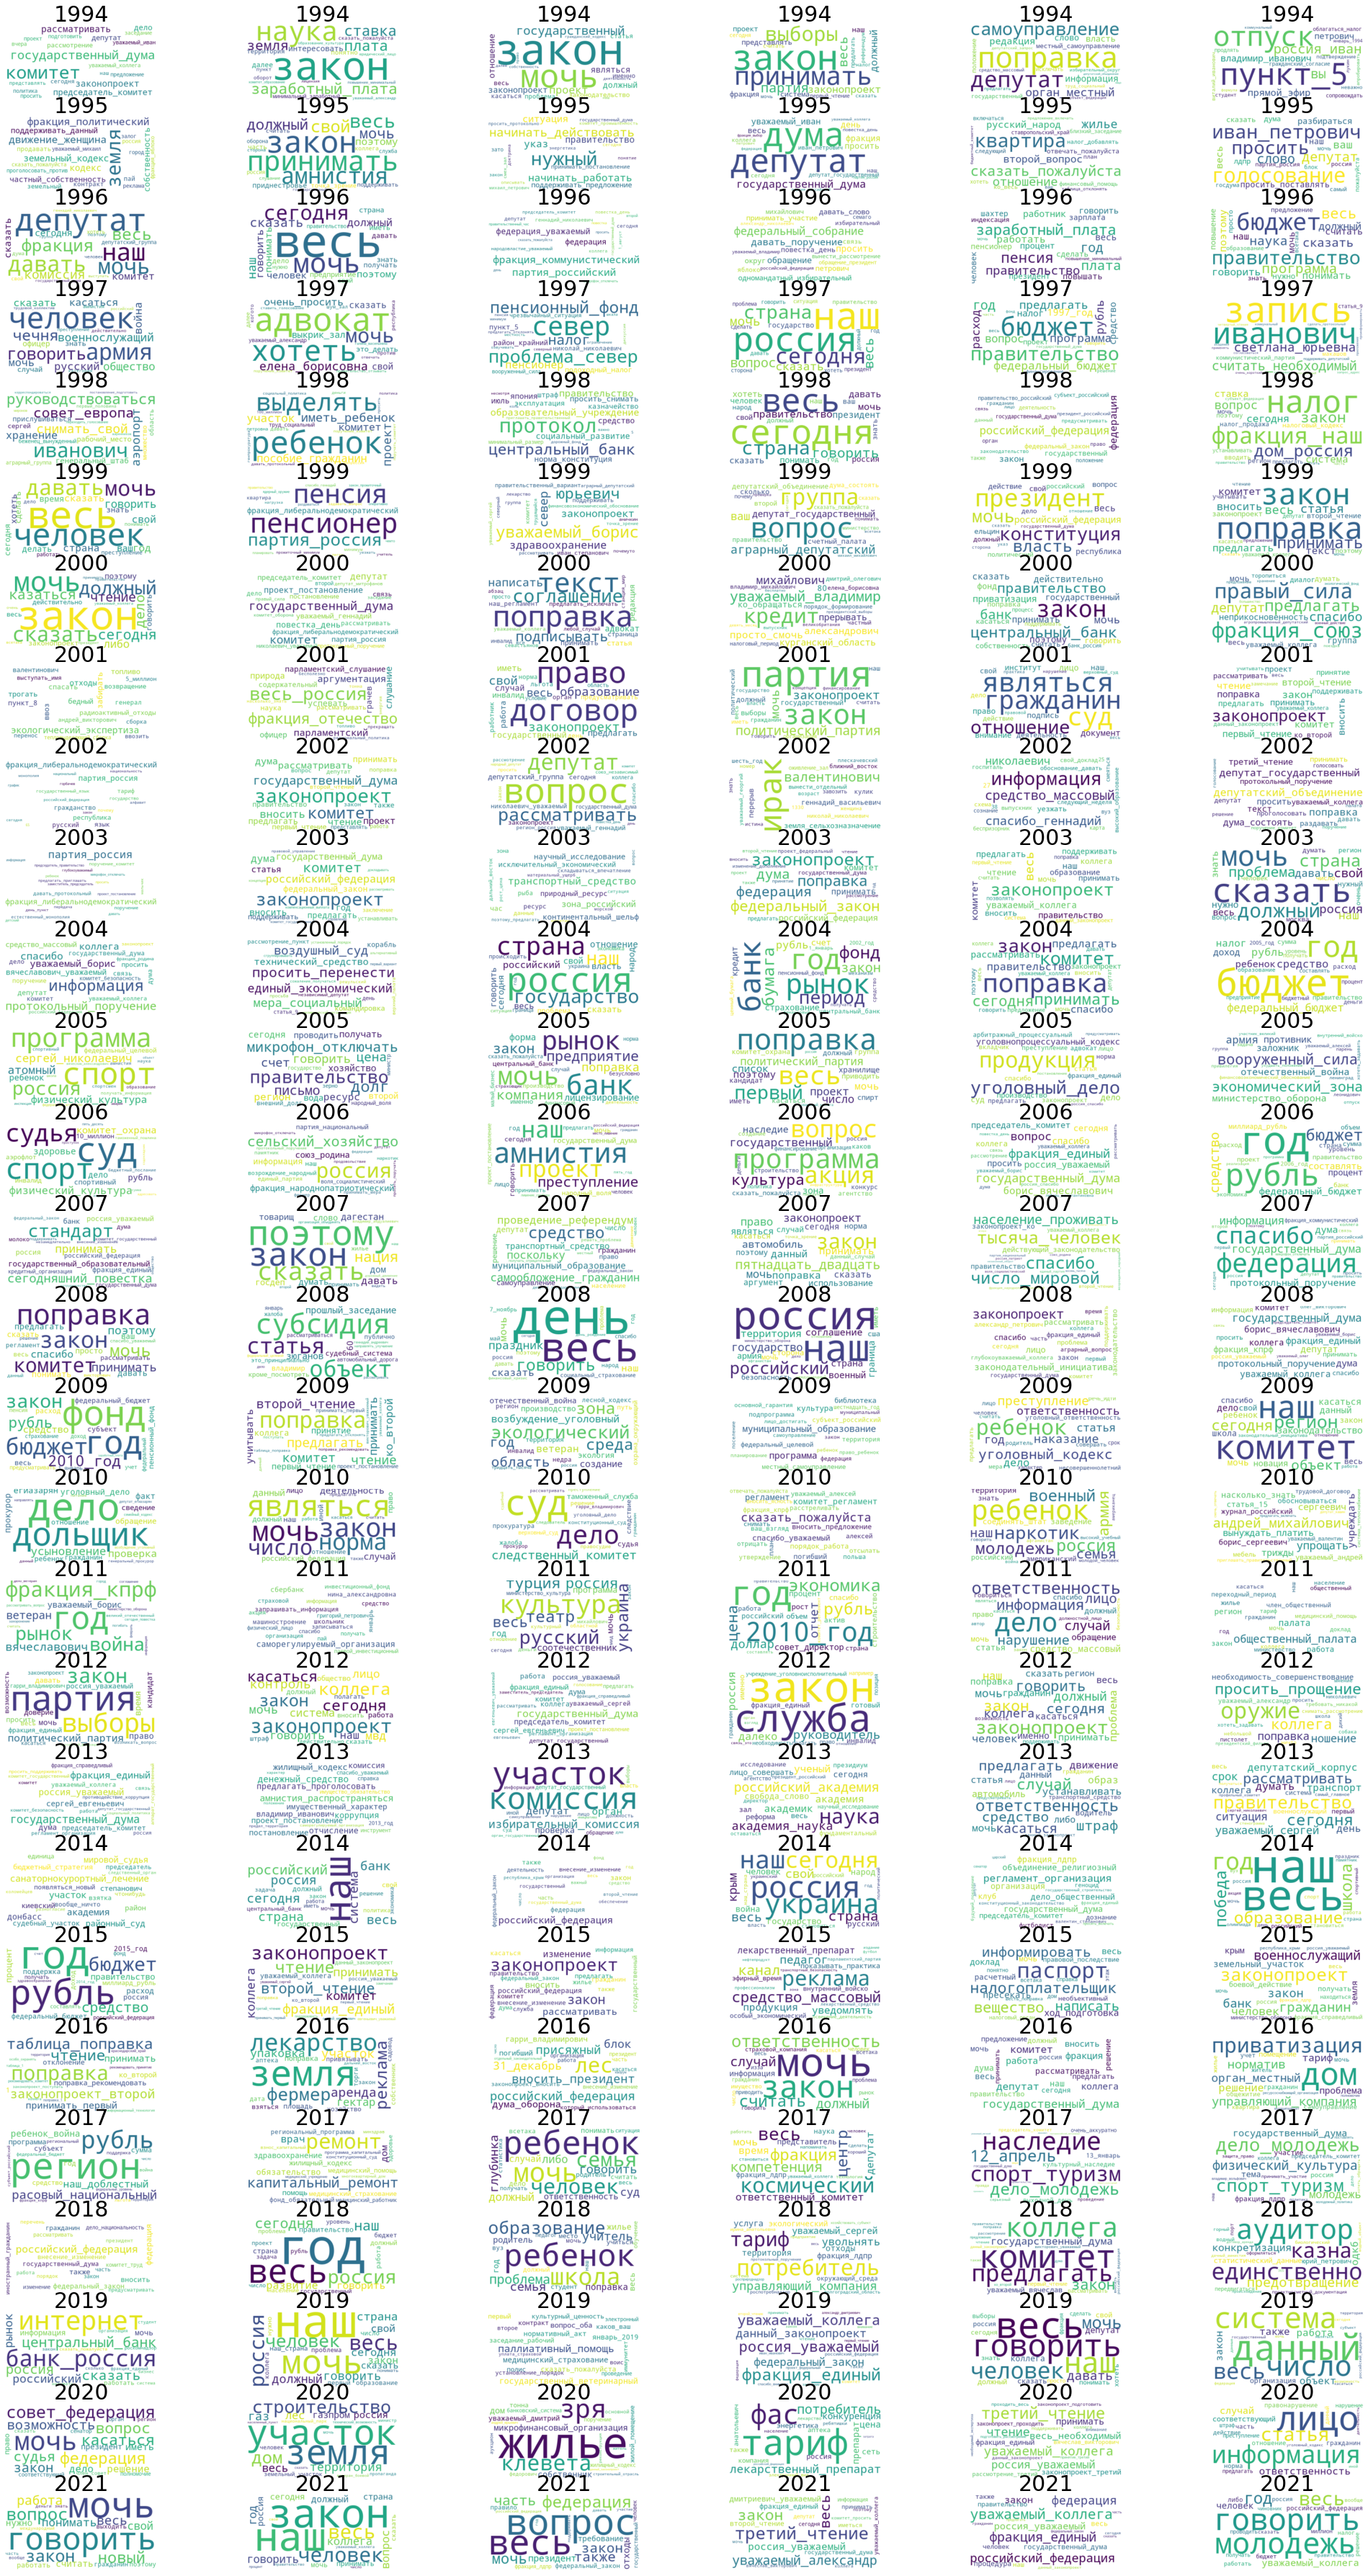

In [23]:
# Визуализация с помощью WordCloud
fig, axs = plt.subplots(28, 6, figsize=(35, 65))
j = 0
for i in top:
    topic = i[1]
    for k in topic:
        ax = axs[j//6,j%6]
        wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(k[1]))
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set(title = i[0])
        ax.title.set_size(30)
        j += 1

## Выводы:

- Очень отчётливо раздедились года по отдельным кластерам, что показывает Umap визуализация;
- Также отчетливо поделились партии по каждому году в отдельности;
- Часть тем удаётся интерпритировать по годам, часть нет.